In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/10m-cultural/CHANGELOG
/kaggle/input/10m-cultural/README.md
/kaggle/input/10m-cultural/VERSION
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.cpg
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries_nep.shp
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_boundary_lines_maritime_indicator_chn.shp
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries_ita.prj
/kaggle/input/10m-cultural/10m_cultural/ne_10m_urban_areas.VERSION.txt
/kaggle/input/10m-cultural/10m_cultural/ne_10m_parks_and_protected_lands_scale_rank.shp
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries_mar.shx
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries_bdg.prj
/kaggle/input/10m-cultural/10m_cultural/ne_10m_populated_places.README.html
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries_ita.README.html
/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_pacific_groupings.README.html
/kaggle/input/10m-c

This notebook will make maps of the various mexican cities, the urban centers and road networks that the country possesses, so we can get a better idea of the infraestructure and population distribution of the country. We will be using the Natural Earth 10m cultural data set to get our information and .shp files. You can get them or check them out here: https://www.naturalearthdata.com/downloads/

First of all we need to import the libraries we will be using these include geopandas, shapely, rasterio and other libraries so we can plot maps, read the data and generate images.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely.geometry import mapping
from rasterio import mask as msk

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


The dataset contains a shape file of the entire world, for now we will narrow it down only to Mexico

In [3]:
world = gpd.read_file('/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_0_countries.shp')

world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


<AxesSubplot:>

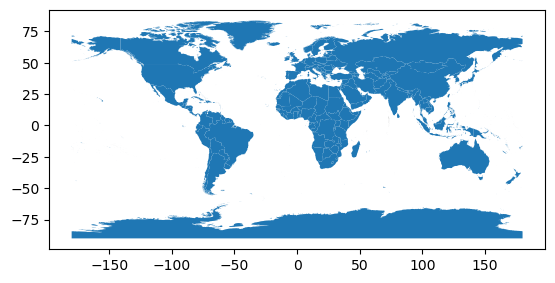

In [4]:
world.plot()

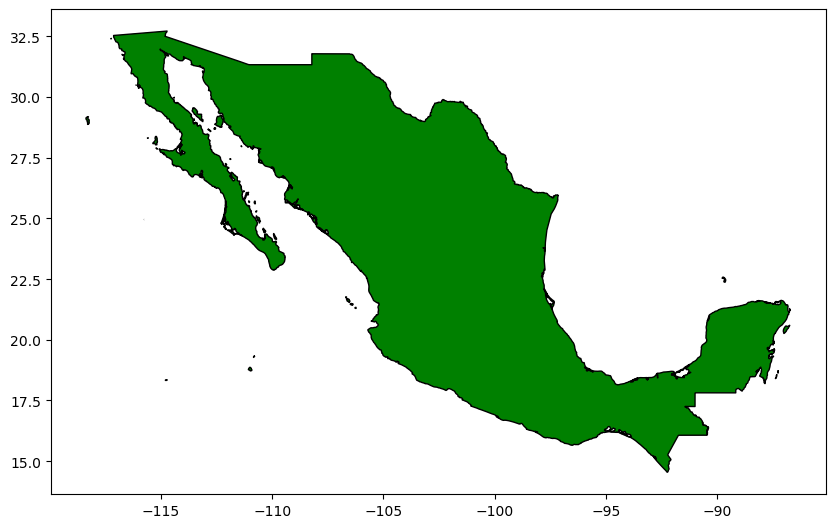

In [5]:
mexico = world[world['SOVEREIGNT'] == 'Mexico']

fig, ax = plt.subplots(figsize=(10,10))
mexico.plot(ax=ax, color = 'green', edgecolor = 'black')
plt.show()

Since Mexico is a Federal Republic we will also devide the map further by adding the mexican states

In [6]:
mexican_states_pd = gpd.read_file('/kaggle/input/10m-cultural/10m_cultural/ne_10m_admin_1_states_provinces.shp')

mexican_states = mexican_states_pd[mexican_states_pd['iso_a2'] == 'MX']

mexican_states.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
1255,Admin-1 states provinces,4,MEX-2712,2712,MX-SON,None,MX,6,Sonora,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-114.81937 32.49936, -114.8167..."
1256,Admin-1 states provinces,4,MEX-2706,2706,MX-BCN,None,MX,6,Baja California,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-114.72428 32.71284, -114.7238..."
1259,Admin-1 states provinces,4,MEX-2709,2709,MX-CHH,None,MX,1,Chihuahua,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-108.21512 31.77775, -108.18928 31.7..."
1261,Admin-1 states provinces,4,MEX-2708,2708,MX-COA,None,MX,1,Coahuila,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-102.32101 29.89394, -102.30217 29.8..."
1262,Admin-1 states provinces,4,MEX-2716,2716,MX-TAM,None,MX,5,Tamaulipas,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-99.71067 27.67012, -99.70569 ..."


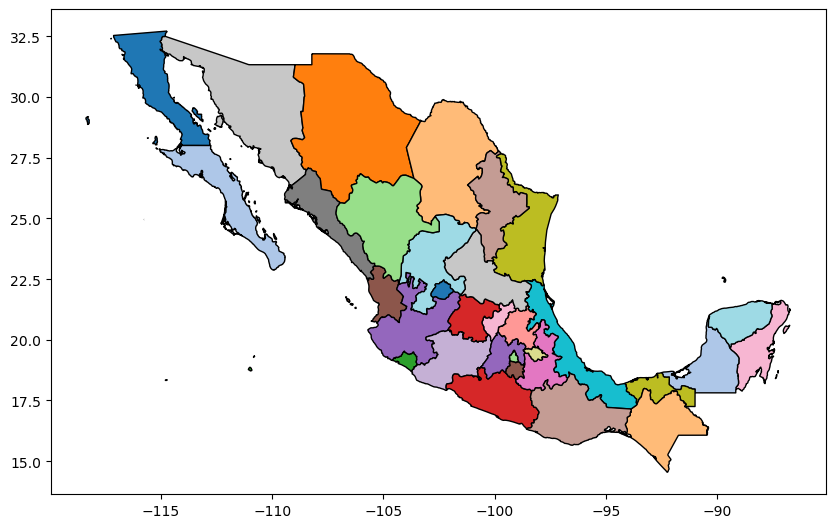

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
mexican_states.plot(column='iso_3166_2', ax=ax, cmap = 'tab20', edgecolor='black')

plt.show()

Now the first step on our map, the cities. We will add a red to blue color gradient to represent the differences in population (from 2020) between them. My prediction will be that Mexico City, most likely will be the only red city.

In [8]:
cities = gpd.read_file('/kaggle/input/10m-cultural/10m_cultural/ne_10m_populated_places.shp')

mexico_cities = cities[cities['SOV0NAME'] == 'Mexico']

mexico_cities.head()

,SCALERANK,NATSCALE,LABELRANK,FEATURECLA,NAME,NAMEPAR,NAMEALT,NAMEASCII,ADM0CAP,CAPIN,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
1112,8,10,2.0,Populated place,Vicente Guerrero,None,None,Vicente Guerrero,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-116.00926 30.76405)
1113,8,10,2.0,Populated place,Loreto,None,None,Loreto,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-111.35166 26.01333)
1114,8,10,2.0,Populated place,Ciudad Constitución,None,None,Ciudad Constitucion,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-111.65999 25.04001)
1115,8,10,2.0,Populated place,Allende,None,None,Allende,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-100.84998 28.32999)
1116,8,10,2.0,Populated place,Nueva Rosita,None,None,Nueva Rosita,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-101.21998 27.94996)


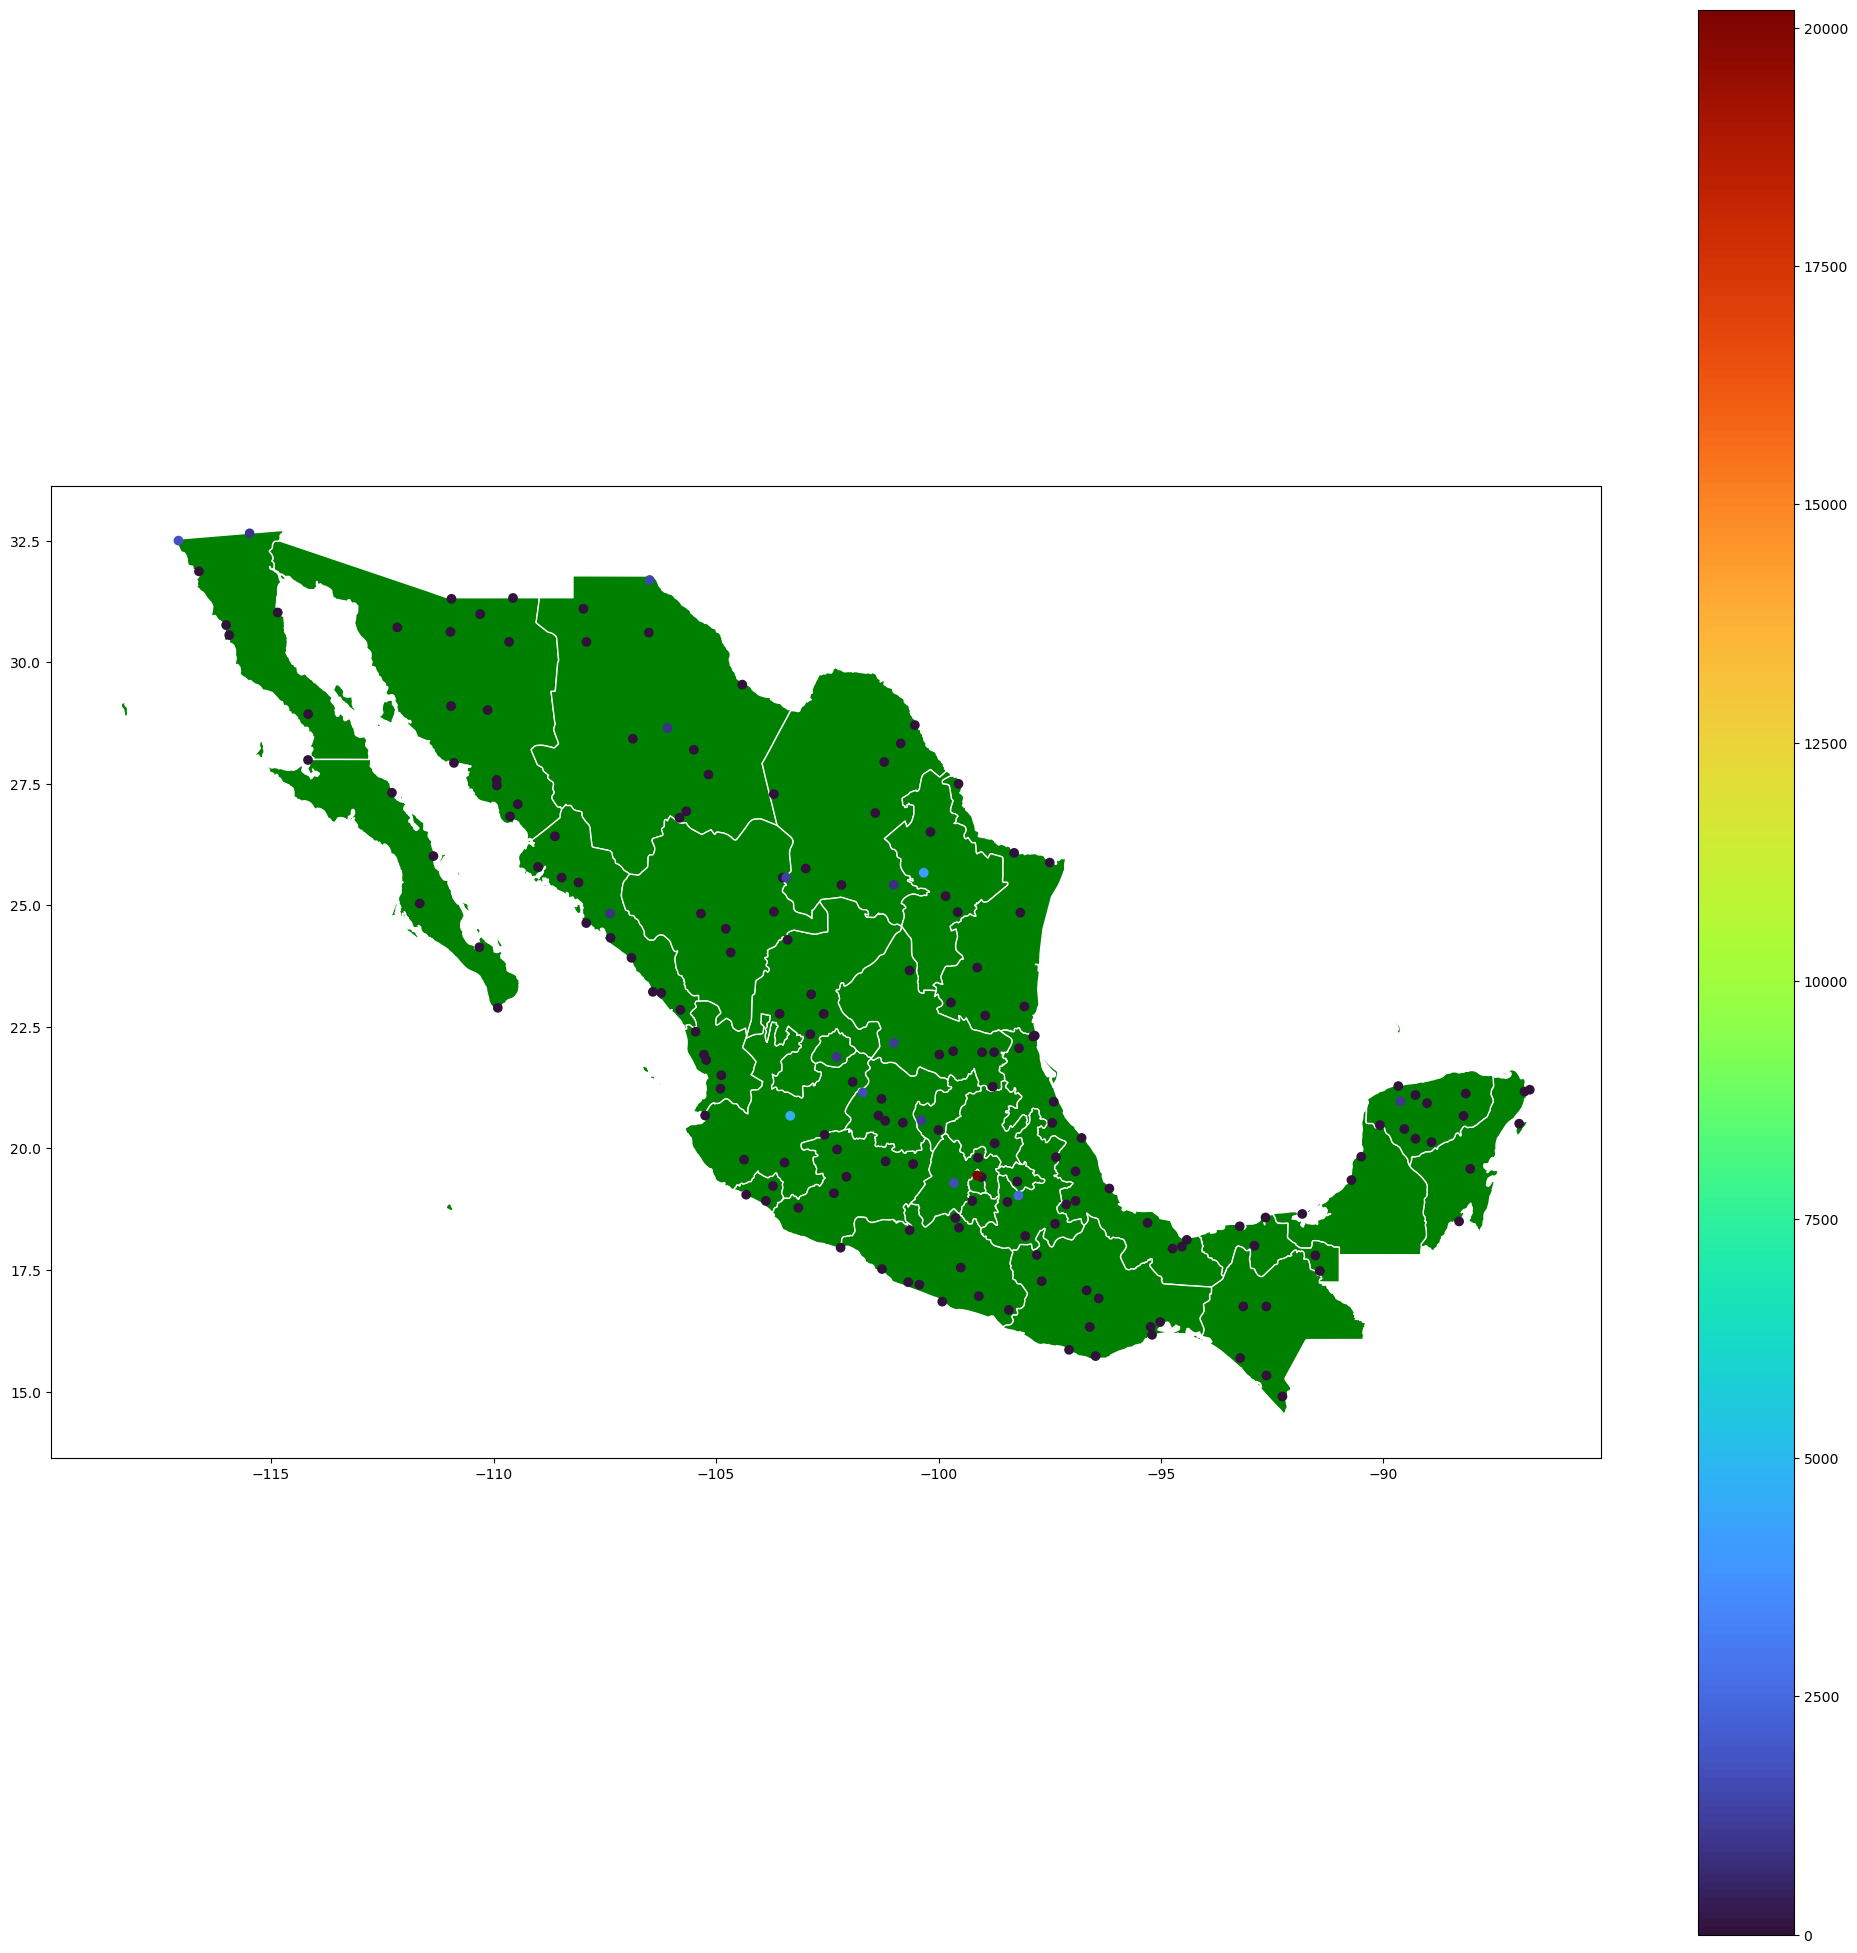

In [9]:
fig, ax = plt.subplots(figsize=(25,25))
mexican_states.plot(ax=ax, color='green', edgecolor='white')
mexico_cities.plot(column='POP2020', cmap='turbo', legend=True, ax=ax)
plt.show()

Mexico City is one of the biggest cities in the world and as the map shows, the biggest city in the country by far. Just to get a different perspective now we will load another shp file this time it's from urban areas. For this shp file we will need to link it to the others with intersections between the polygons of this image and our maps, since it doesn´t have a column with the name of the country.

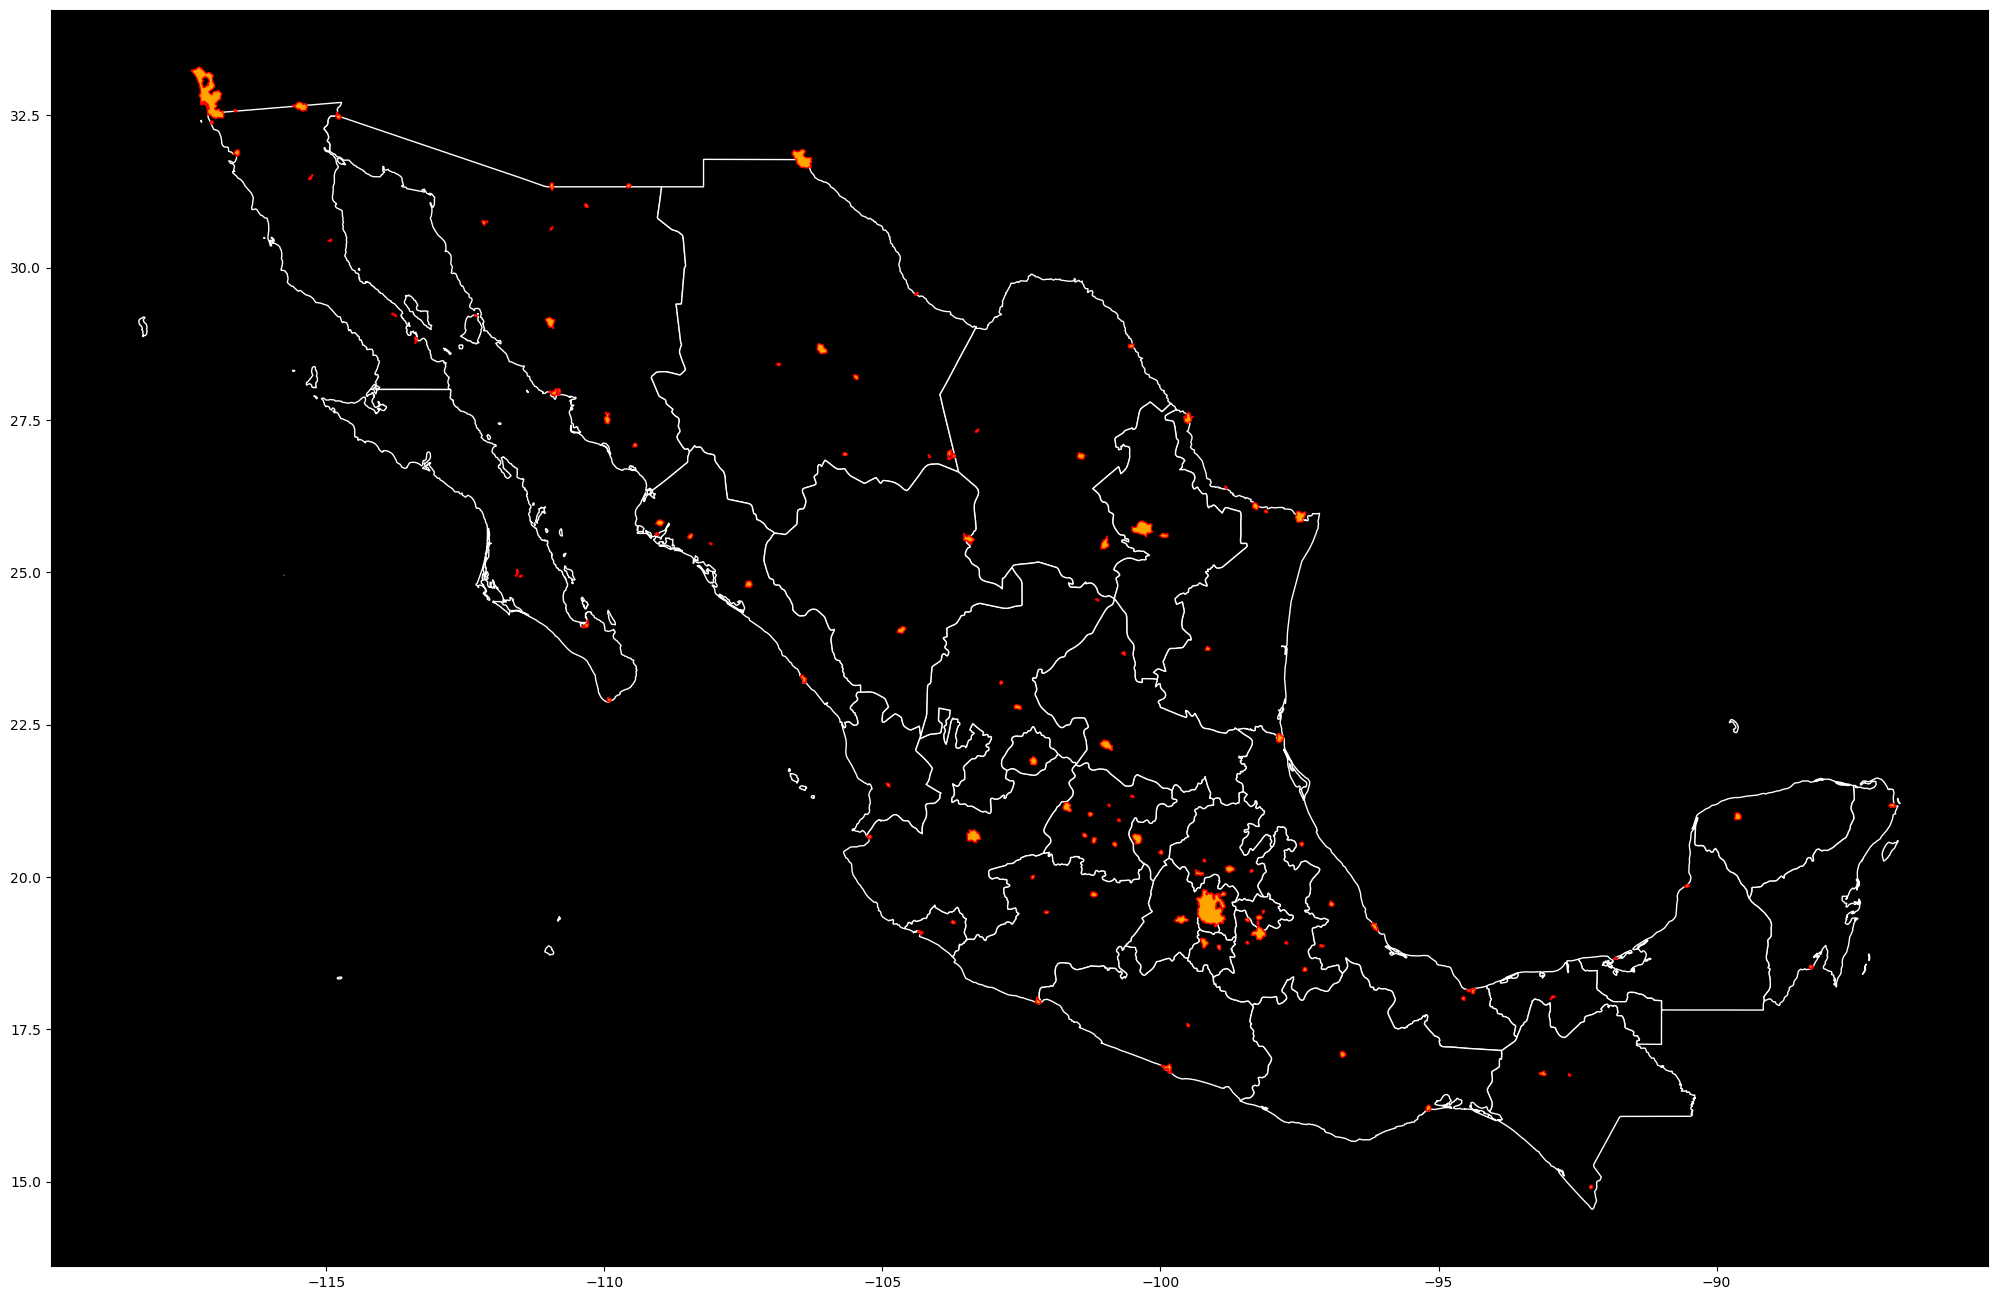

In [10]:
urban_areas = gpd.read_file('/kaggle/input/10m-cultural/10m_cultural/ne_10m_urban_areas.shp')

urban_areas_mexico = gpd.sjoin(urban_areas, mexican_states_pd, how='inner', predicate='intersects')

urban_areas_mexico = urban_areas_mexico.loc[urban_areas_mexico['iso_a2'] == 'MX']

fig, ax = plt.subplots(figsize=(25,25))
ax.set_facecolor ('black')
mexican_states.plot (ax = ax, color = 'black', edgecolor = 'white')
urban_areas_mexico.plot(color = 'orange', ax=ax, edgecolor = 'red')
plt.show()

Here we can see a better representation of just how big the Mexico City metro area is compared to the other cities in the country, and also how border cities extend.

Lastly we will load the final shp file, the roads of Mexico, we will also color code them depending on their type, and finally overlay the info into our cities map, but this time the cities will be blue to avoid color overload.

In [11]:
roads = gpd.read_file('/kaggle/input/10m-cultural/10m_cultural/ne_10m_roads.shp')
#roads.head()

mexico_roads = roads[roads['sov_a3'] == 'MEX']
mexico_roads.head()

,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,...,rwdb_rd_id,orig_fid,prefix,uident,continent,expressway,level,min_zoom,min_label,geometry
8,3,Road,Secondary Highway,MEX,None,"Version 1.5: Changed alignment, a few adds in ...",195,None,None,None,...,0,0,None,289505,North America,0,Federal,3.0,6.0,"LINESTRING (-92.97903 16.72735, -92.95993 16.7..."
9,7,Road,Major Highway,MEX,None,"Version 1.5: Changed alignment, a few adds in ...",119,None,None,None,...,0,0,None,273505,North America,1,Federal,7.0,9.5,"LINESTRING (-98.12629 20.12761, -98.15755 20.0..."
10,3,Road,Major Highway,MEX,None,"Version 1.5: Changed alignment, a few adds in ...",None,None,None,None,...,0,0,None,276705,North America,1,Interstate,3.0,6.0,"LINESTRING (-99.30891 19.34093, -99.26724 19.3..."
11,7,Road,Secondary Highway,MEX,None,"Version 1.5: Changed alignment, a few adds in ...",15,None,None,None,...,0,0,None,278205,North America,0,Federal,7.0,9.5,"LINESTRING (-99.64234 19.28709, -99.75001 19.2..."
12,8,Road,Secondary Highway,MEX,None,"Version 1.5: Changed alignment, a few adds in ...",37,None,None,None,...,0,0,None,286105,North America,0,Federal,7.1,9.6,"LINESTRING (-102.32712 18.04369, -102.32017 18..."


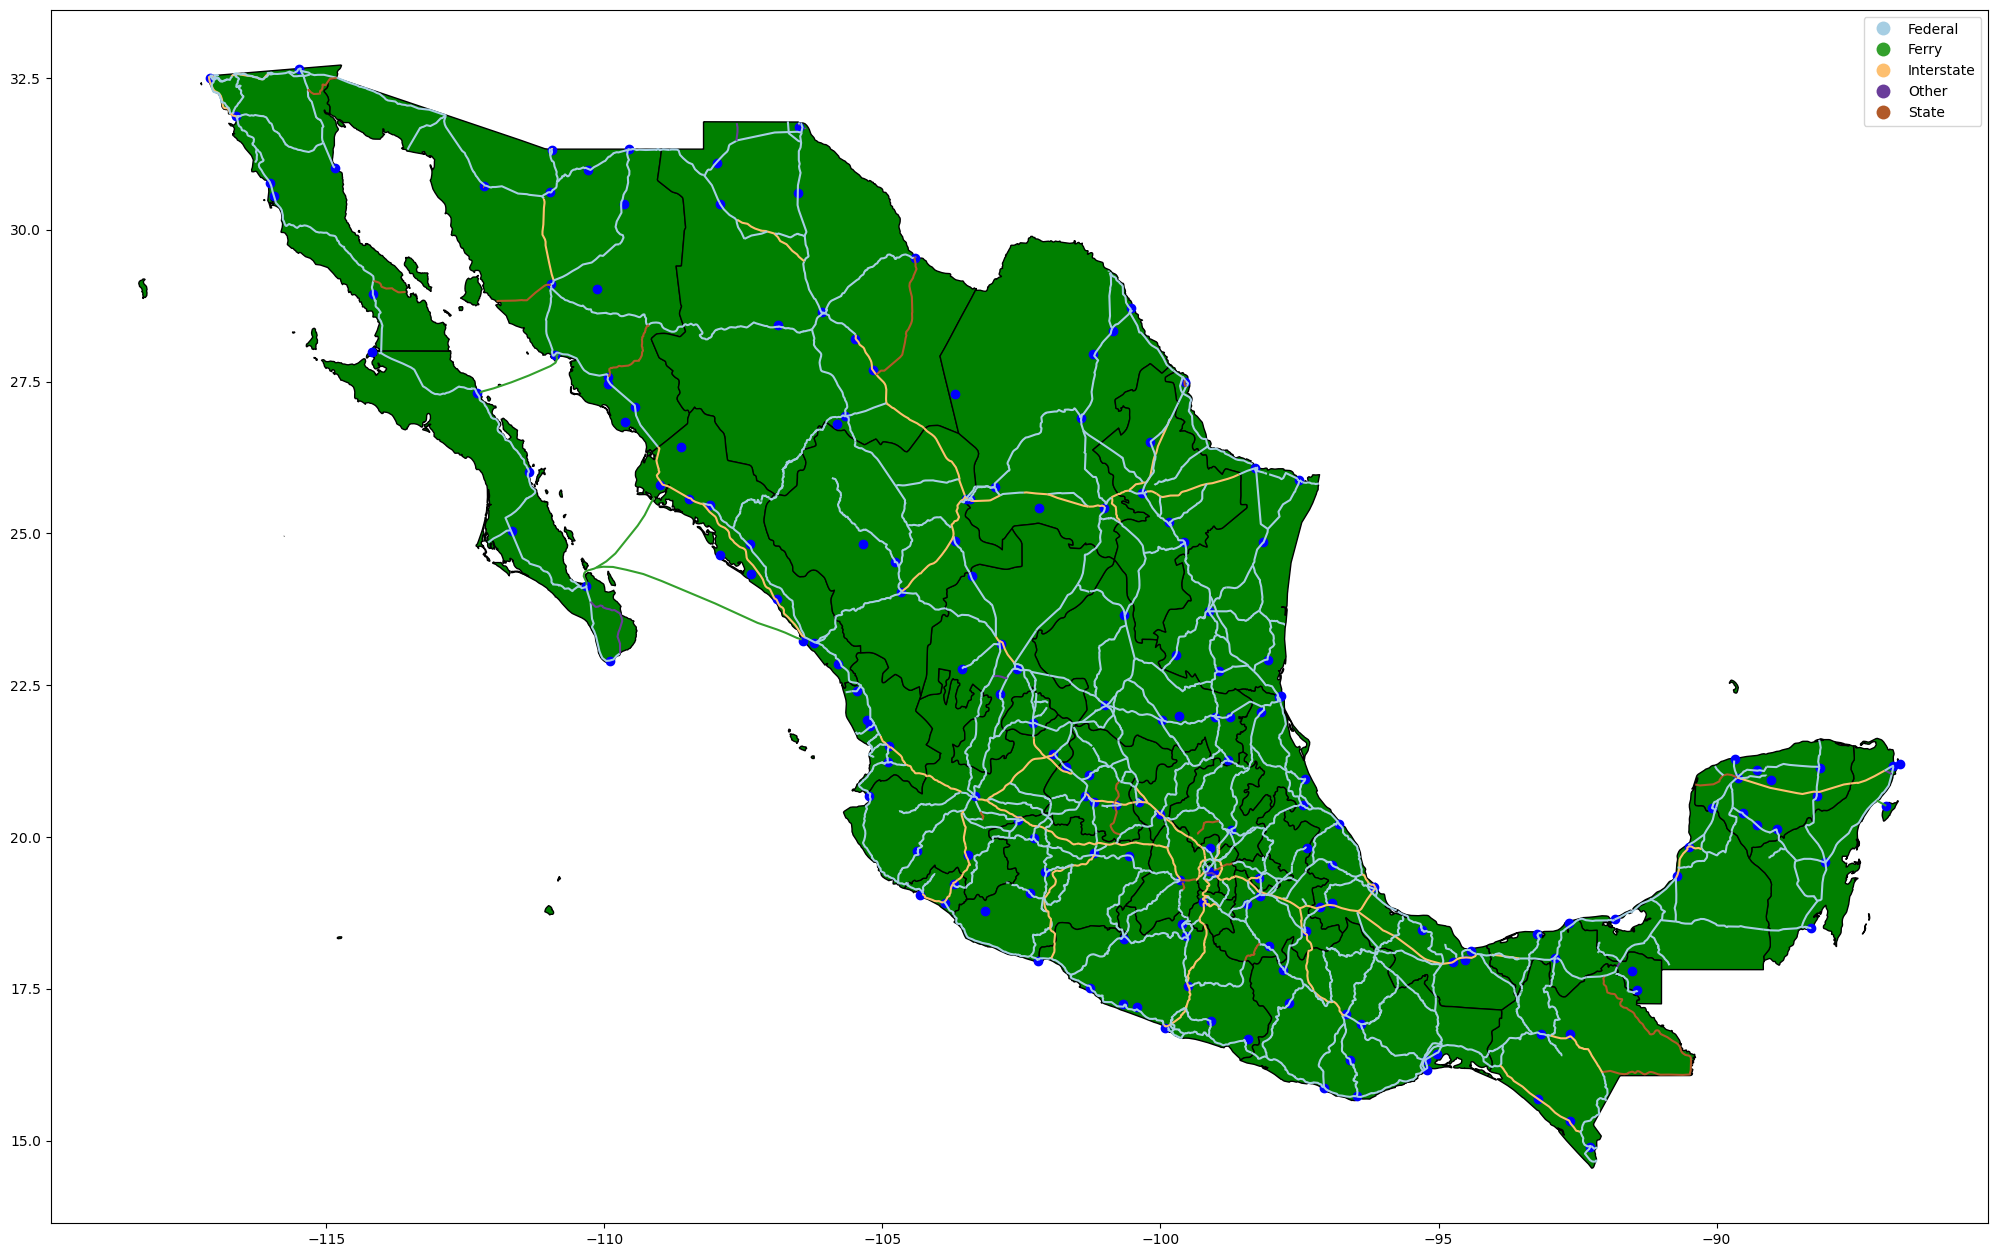

In [12]:
fig, ax = plt.subplots(figsize=(25,25))
mexican_states.plot(ax=ax, color='green', edgecolor='black')
mexico_cities.plot(ax=ax, color = 'blue')
mexico_roads.plot(column='level', cmap='Paired', legend=True, ax=ax)
plt.show()

Here we can see that roads and cities intersect most of the time. Also how the road network gets more spread the more you get away from the core of the country, this not only can be explained by seeing our urban areas map, but also by looking at a geographical map of Mexico, since the north and south is filled with hard to develop terrain and biomes. 